# 📄 Report Tecnico Finale: Analisi `velocity.csv` e Sintesi Comparativa

## 1. Focus Specifico: Il Dataset Velocità (`velocity.csv`)
Il terzo dataset analizzato rappresenta la componente cinetica della simulazione.

### A. Natura del Dato
* **Significato Fisico:** Rappresenta la velocità istantanea $\vec{v}$ di ogni atomo. È il tasso di variazione della posizione nel tempo ($\vec{v} = d\vec{r}/dt$).
* **Comportamento Dinamico:** Dai grafici emerge un comportamento **oscillatorio ad alta frequenza** (simile alle forze). Gli atomi vibrano rapidamente attorno a posizioni di equilibrio.
* **Problematica di Ingestione:** Come per il file *forces*, il file *velocity* presentava un formato non standard (separatori basati su spazi multipli/whitespace invece di tabulazioni). È stato necessario applicare un algoritmo di **Parsing Robusto** (lettura raw + split manuale) per recuperare correttamente le colonne.

### B. Analisi Dimensionale (Il Problema della Scala)
L'analisi statistica ha rivelato un range di valori molto contenuto:
* **Range Rilevato:** $\approx -8.0$ a $+8.0$ nm/ps.
* **Confronto:** Questi valori sono drasticamente inferiori alle Forze (che arrivano a 6000) e inferiori anche alle Coordinate (fino a 60).
* **Rischio:** Questo fenomeno è noto come **"Vanishing Scale"**. Se i dati non vengono normalizzati, la Rete Neurale tratterà le velocità come "rumore trascurabile" rispetto alle forze, ignorando informazioni cruciali sulla direzione del movimento.

---

## 2. Tabella Comparativa "Grand View" (Sintesi Step 1)
La seguente tabella riassume l'analisi dell'intero set di dati. Evidenzia le differenze critiche che giustificano le operazioni di pulizia e normalizzazione pianificate per il Merge finale.

| Caratteristica | 🟢 **Coordinates** ($X$) | 🟠 **Velocity** ($V$) | 🔴 **Forces** ($F$) |
| :--- | :--- | :--- | :--- |
| **Contenuto Fisico** | Posizione Spaziale | Velocità di Spostamento | Spinta/Accelerazione |
| **Shape (Dimensioni)** | `(50001, 415)` | `(50001, 415)` | `(50001, 415)` |
| **Separatore File** | Standard (`;`) | Irregolare (Spazi) | Irregolare (Tab) |
| **Range Valori (Approx)** | $+20 \dots +60$ | $-8 \dots +8$ | $-6700 \dots +6400$ |
| **Ordine di Grandezza** | $10^1$ (Medio) | $10^0$ (Molto Basso) | $10^3$ (Molto Alto) |
| **Dinamica Temporale** | **Smooth** (Fluida) | **Noisy** (Vibratoria) | **Noisy** (Caotica) |
| **Azione Preprocessing** | Drop Timestamp | Drop Timestamp + **Scaler** | Drop Timestamp + **Scaler** |

---

## 3. Strategia di Merge e Preprocessing
Sulla base della tabella comparativa, la strategia per la creazione del `dataset_completo.npy` (Input Shape: 1242) è definita come segue:

1.  **Uniformità Temporale:** La colonna 0 (Timestamp) è identica in tutti i file e monotonicamente crescente. Viene rimossa poiché l'informazione temporale sarà implicita nella sequenza dei dati.
2.  **Concatenazione:** I tensori verranno uniti lungo l'asse delle colonne (`axis=1`).
    * Struttura Finale: $[X_1..X_{414} \mid V_1..V_{414} \mid F_1..F_{414}]$
3.  **Normalizzazione Differenziata:**
    * Non è possibile usare un unico Scaler globale.
    * Sarà necessario applicare trasformazioni separate (o uno `StandardScaler` column-wise) per garantire che Forze ($10^3$) e Velocità ($10^0$) contribuiscano equamente al gradiente durante l'addestramento della rete neurale.

## 4. Conclusione
Tutti i dati grezzi sono stati validati, riparati e compresi. Siamo pronti per generare il file binario unico che alimenterà i modelli di Deep Learning nello Step 2.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 1. FUNZIONE DI ANTEPRIMA (Per vedere la struttura) ---
def mostra_anteprima_smart(df, n_righe=5):
    if df is None: return
    print(f"\n ANTEPRIMA DATASET | Shape: {df.shape}")
    print("-" * 80)
    if df.shape[1] > 10:
        indici_da_vedere = np.r_[0:4, df.shape[1]-3:df.shape[1]]
        preview = df.iloc[:n_righe, indici_da_vedere]
        print(preview.to_string(index=False))
        print(f"\n      ... [ {df.shape[1] - 7} colonne centrali nascoste ] ...")
    else:
        print(df.head(n_righe))
    print("-" * 80)

In [4]:
# --- 2. CARICAMENTO ROBUSTO ---
file_path = 'velocity.csv'
print(f"--- Analisi Approfondita di: {file_path} ---\n")

--- Analisi Approfondita di: velocity.csv ---



Rilevato fallimento separatore Tab. Avvio riparazione basata sugli spazi...
Conversione da testo a numeri in corso... (può richiedere qualche secondo)

--- RISULTATO RIPARAZIONE ---
Nuova Shape: (50001, 415)
✅ SUCCESSO! Abbiamo recuperato le 415 colonne.
Range Velocità: Min -8.7794 | Max 7.7679


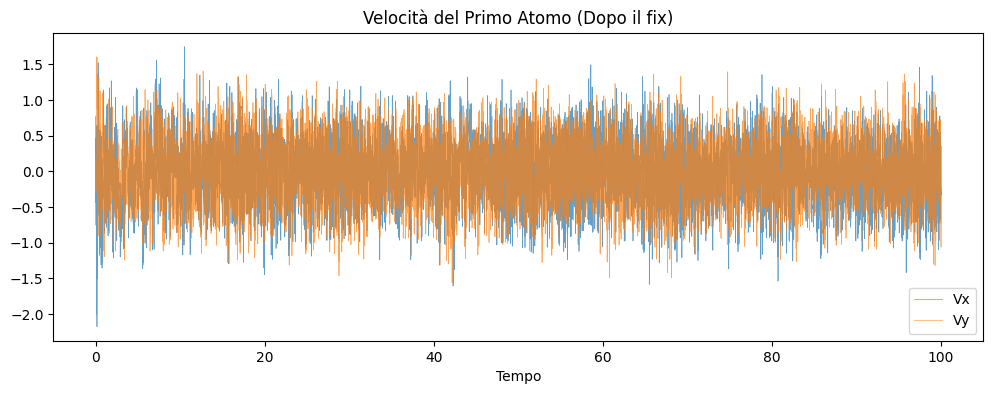

In [ ]:
df = None

try:
    # engine='python' è più tollerante agli errori
    df = pd.read_csv(file_path, sep='\t', header=None, index_col=False, engine='python')
except Exception as e:
    print(f"Tentativo standard fallito. Passo al metodo manuale...")

print("Rilevato fallimento separatore Tab. Avvio riparazione basata sugli spazi...")

# 1. Se df esiste ma ha 1 sola colonna, lo usiamo. Altrimenti ricarichiamo "raw".
if 'df' not in locals() or df is None:
    # Carichiamo tutto come righe grezze
    df = pd.read_csv('velocity.csv', sep='|', header=None, engine='python')

# 2. SPLIT SUGLI SPAZI (Whitespace)
# expand=True dice a pandas: "se trovi uno spazio, crea una nuova colonna"
# Questo funziona sia per spazi singoli che multipli
df_fixed = df[0].str.split(expand=True)

# 3. CONVERSIONE IN NUMERI
print("Conversione da testo a numeri in corso... (può richiedere qualche secondo)")
df_final = df_fixed.apply(pd.to_numeric, errors='coerce')

# 4. VERIFICA FINALE
print(f"\n--- RISULTATO RIPARAZIONE ---")
print(f"Nuova Shape: {df_final.shape}")

if df_final.shape[1] == 415:
    print("✅ SUCCESSO! Abbiamo recuperato le 415 colonne.")
    
    # Sovrascriviamo il vecchio df rotto con quello nuovo
    df = df_final
    
    # Statistiche veloci
    vel_only = df.drop(columns=[0]) # Via il tempo per il calcolo
    print(f"Range Velocità: Min {vel_only.min().min():.4f} | Max {vel_only.max().max():.4f}")
    
    # Visualizziamo il grafico per conferma
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))
    plt.plot(df[0], df[1], label='Vx', alpha=0.7, linewidth=0.5)
    plt.plot(df[0], df[2], label='Vy', alpha=0.7, linewidth=0.5)
    plt.title("Velocità del Primo Atomo (Dopo il fix)")
    plt.xlabel("Tempo")
    plt.legend()
    plt.show()
else:
    print(f"⚠️ Ancora problemi. Colonne trovate: {df_final.shape[1]}")
    print("Mostrami le prime righe per capire il separatore:")
    print(df_fixed.head())

✅ CARICAMENTO RIUSCITO. Shape: (50001, 415)

2. RANGE VALORI: Min -8.7794 | Max 7.7679
   (Le velocità dovrebbero essere numeri più piccoli delle forze, ma oscillanti)

📊 ANTEPRIMA DATASET | Shape: (50001, 415)
--------------------------------------------------------------------------------
  0         1         2         3         412       413      414
0.000  0.772800 -0.057800 -0.025800 -0.057100 -0.708000 0.159300
0.002  0.612864 -0.078231 -0.147710 -0.042385 -0.504651 0.265599
0.004  0.352195 -0.109924 -0.294609 -0.038858 -0.326192 0.332929
0.006  0.111483 -0.112904 -0.482127 -0.057508 -0.242379 0.365180
0.008 -0.019388 -0.070366 -0.690919 -0.099081 -0.227398 0.347753

      ... [ 408 colonne centrali nascoste ] ...
--------------------------------------------------------------------------------

3. GRAFICO: Velocità del primo atomo


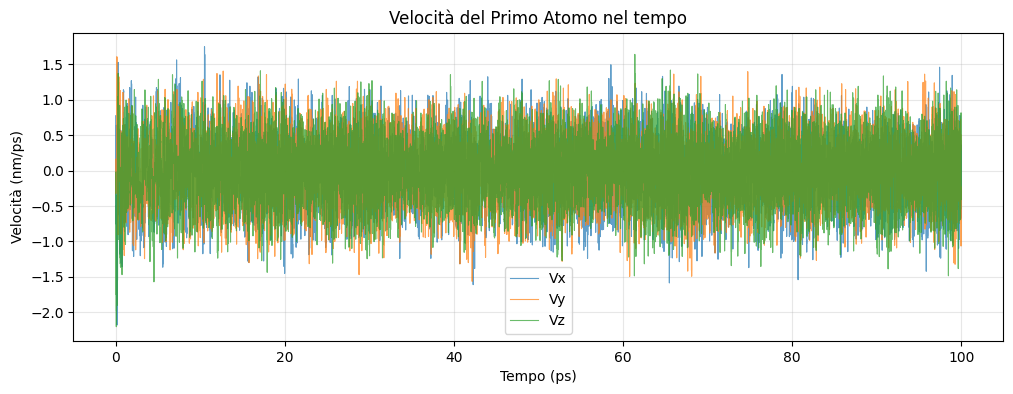

In [10]:
# --- 3. CONVERSIONE E ANALISI ---
if df is not None:
    # Convertiamo tutto in numeri (fondamentale!)
    df = df.apply(pd.to_numeric, errors='coerce')
    
    # Check Shape
    if df.shape[1] == 415:
        print(f"✅ CARICAMENTO RIUSCITO. Shape: {df.shape}")
        
        # Statistiche (Escludendo colonna 0 tempo)
        vel_only = df.drop(columns=[0])
        v_min = vel_only.min().min()
        v_max = vel_only.max().max()
        
        print(f"\n2. RANGE VALORI: Min {v_min:.4f} | Max {v_max:.4f}")
        print("   (Le velocità dovrebbero essere numeri più piccoli delle forze, ma oscillanti)")

        # Mostriamo la tabella carina
        mostra_anteprima_smart(df)

        # Grafico
        print("\n3. GRAFICO: Velocità del primo atomo")
        plt.figure(figsize=(12, 4))
        plt.plot(df[0], df[1], label='Vx', alpha=0.7, linewidth=0.8)
        plt.plot(df[0], df[2], label='Vy', alpha=0.7, linewidth=0.8)
        plt.plot(df[0], df[3], label='Vz', alpha=0.7, linewidth=0.8)
        plt.title("Velocità del Primo Atomo nel tempo")
        plt.xlabel("Tempo (ps)")
        plt.ylabel("Velocità (nm/ps)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
    else:
        print(f"⚠️ ATTENZIONE: Numero colonne strano ({df.shape[1]}). Controlla il separatore.")
else:
    print("Fallimento totale nel caricamento.")